# Biquad Alignment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from IIRSimUtils import *
from FrequencyResponse import *
from FPGATestIO import *
from scipy.special import eval_chebyu

## Alignment Pulse and Coefficients

In [14]:
# Parameters for the filter configuation
TRIALS = 1
NOTCH = 650
Q_FACTOR = 2
ADVANCE=3
USING_NOTCH=False

# Used for aligning final verilog output with input. Not yet aligned (144 prior to incremental)
verilog_nominal_latency = 18*8
b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

# Retrieve and fill Verilog data
verilog_data = []
with open("003_files/outputs/verilog/timing_pulse_a1_8192_a2_8192_advance_%d.dat"%ADVANCE, "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
# Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)

# Retrieve the input data
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_run = pulse_run[ADVANCE:]
pulse_original_samps = pulse_run.copy()

# Cut off the trailing inputs, as they will not be reflected in recorded output due to the latency
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()

# Debug information to make sure intput/output are the same length
if(len(verilog_data) != len(pulse_run)):
    print("Warning: input and output data lengths are different!")
    print("Output Data Length: %s\nInput data Length:  %s"%(len(verilog_data), len(pulse_run)))

if(USING_NOTCH):
    # Retrieve the coefficients used to configure the notch filter
    coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

Output Data Length: 79912
Input data Length:  80061


In [15]:
if(USING_NOTCH):
    # Generate python-only output
    python_data_IIR = iir_biquad_run_fixed_point(pulse_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
    python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_samps.copy())),dtype=np.int64)
    python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) ,14)
    
    python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
    python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
    python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()
    
    lfilter_data_IIR = lfilter([1,0,0],a, pulse_samps.copy()) 
    lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()
    lfilter_data = lfilter(b,a, pulse_samps.copy()) 
    lfilter_data_trimmed = lfilter_data.copy()

In [16]:
# Make lengths divisible by 8s
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
pulse_run = pulse_run[:clipped_length]

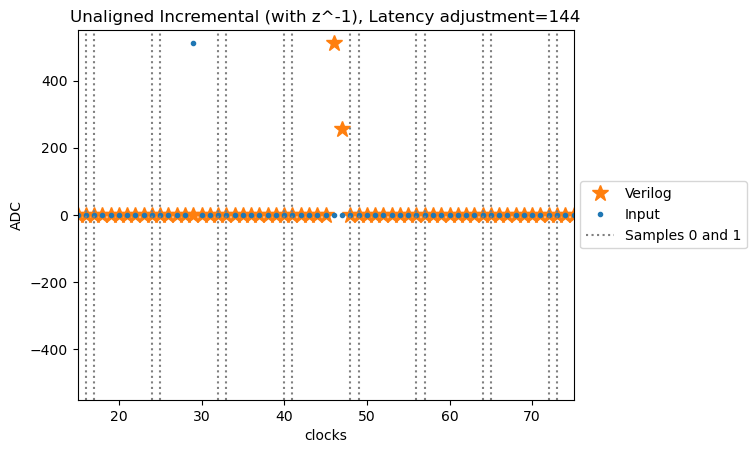

In [18]:
# clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(incremental_data)]))
# print("Clipped Length: %s"%(clipped_length))
# print("Incremental Data Length: %s"%(len(incremental_data)))
# print("Pulse Run Length: %s"%(len(pulse_run)))
# print("Clocks Length: %s"%(len(clocks)))
plt.plot(clocks, incremental_data, linestyle="None", marker="*", markersize=12, label="Verilog", color="C1")
# plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C2")
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(0,200)
plt.xlim(15,75)
# plt.xlim(140,170)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
# plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Unaligned Incremental (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("003_files/IIR_Impulse.png",dpi=500, bbox_inches='tight')
plt.show()
# print(b_fixed_point_signed/(2**14))
# print(a_fixed_point_signed/(2**14))


## Alignment With Biquad

In [6]:
# Parameters for the filter configuation
TRIALS = 1
NOTCH = 650
Q_FACTOR = 8
USING_NOTCH=False

# Used for aligning final verilog output with input. Not yet aligned (144 prior to incremental)
verilog_nominal_latency = 18*8
b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

# Retrieve and fill Verilog data
verilog_data = []
with open("003_files/outputs/verilog/pulse_output_height_512_incremental_notch_%sMHz_%sQ.dat"%(NOTCH, Q_FACTOR), "r") as in_file:
    # with open("003_files/outputs/verilog/timing_pulse_a1_8192_a2_8192_advance_%d.dat"%ADVANCE, "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
# Cut off the leading outputs, as they will not reflect any real data until the clock reaches latency
verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)

# Retrieve the input data
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_run = pulse_run[ADVANCE:]
pulse_original_samps = pulse_run.copy()

# Cut off the trailing inputs, as they will not be reflected in recorded output due to the latency
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()

# Debug information to make sure intput/output are the same length
if(len(verilog_data) != len(pulse_run)):
    print("Warning: input and output data lengths are different!")
    print("Output Data Length: %s\nInput data Length:  %s"%(len(verilog_data), len(pulse_run)))

if(USING_NOTCH):
    # Retrieve the coefficients used to configure the notch filter
    coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

Output Data Length: 79912
Input data Length:  80060


In [7]:
if(USING_NOTCH):
    # Generate python-only output
    python_data_IIR = iir_biquad_run_fixed_point(pulse_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
    python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_samps.copy())),dtype=np.int64)
    python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) ,14)
    
    python_IIR_trimmed = python_data_IIR[:-verilog_nominal_latency].copy()
    python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
    python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()
    
    lfilter_data_IIR = lfilter([1,0,0],a, pulse_samps.copy()) 
    lfilter_data_IIR_trimmed = lfilter_data_IIR.copy()
    lfilter_data = lfilter(b,a, pulse_samps.copy()) 
    lfilter_data_trimmed = lfilter_data.copy()

In [8]:
# Make lengths divisible by 8s
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
pulse_run = pulse_run[:clipped_length]

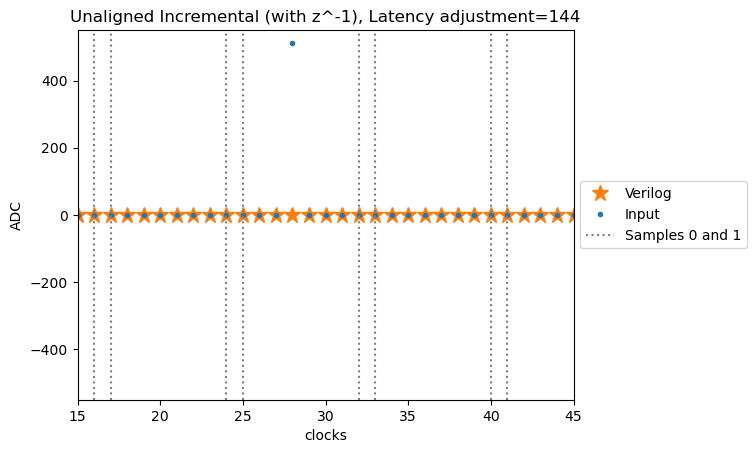

In [9]:
# clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(incremental_data)]))
# print("Clipped Length: %s"%(clipped_length))
# print("Incremental Data Length: %s"%(len(incremental_data)))
# print("Pulse Run Length: %s"%(len(pulse_run)))
# print("Clocks Length: %s"%(len(clocks)))
plt.plot(clocks, incremental_data, linestyle="None", marker="*", markersize=12, label="Verilog", color="C1")
# plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter BQ", alpha=0.8, color="C2")
# plt.plot(clocks, IIR_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR", color="C1")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker=".", label="Input", color="C0")
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")

plt.axvline(x=8*41, linestyle=":", color="grey", label="Samples 0 and 1")
plt.xlim(0,200)
plt.xlim(15,45)
# plt.xlim(140,170)
plt.ylim(-550,550)
# plt.xlim(100,150)
# plt.ylim(-5,5)
# plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Unaligned Incremental (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.xlabel("clocks")
plt.ylabel("ADC")# Put a legend to the right of the current axis
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig("003_files/IIR_Impulse.png",dpi=500, bbox_inches='tight')
plt.show()
# print(b_fixed_point_signed/(2**14))
# print(a_fixed_point_signed/(2**14))
